In [2]:
import pandas as pd
import numpy as np
import datetime
import os
import math
from time import time
from IPython.display import display
from MyTransformers import *
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression, SGDRegressor ,Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor 
import xgboost

from sklearn.model_selection import GridSearchCV


%config IPCompleter.use_jedi = False
%matplotlib inline  

In [3]:
daily_data_path = "Data/London/daily_dataset/daily_dataset/"
daily_weather_path = 'Data/London/weather_daily_darksky.csv'
holiday_data_path = 'Data/London/uk_bank_holidays.csv'

f_data_path = "PrepedData/"
f_test_path = f_data_path + "Test/"
f_hh_path = f_data_path + "HHData/"
f_hhnostd_path = f_data_path + "HHDataNoStd/"
f_hhpastET_path = f_data_path + "HHDataPastET/"

f_energy_all_name = "energy_all.csv"
f_energy_clean_name = "energy_clean"

f_energy_avg_name = f_data_path + "energy_avg"
f_energy_avg_hhourly_name = "energy_avg_hhourly"

f_energy_hh_clean = "energy_hh_clean_all.feather"

mode_path = "Modes/"


## Data Import .Old 

In [139]:
#All info hhourly avg data 
dtypes_in_hh_avg = {'avg_energy':'float32','minute': 'uint8', 'hour': 'uint8', 'day': 'uint8', 'month': 'uint8', 'year': 'uint8',
                    'temperature': 'float16', 'holiday_ind': 'uint8'}
f_energy_hh_avg = pd.read_csv(f_data_path+f_energy_avg_hhourly_name+ '_all.csv', dtype=dtypes_in_hh_avg)

energy_hh_avg = f_energy_hh_avg.drop('avg_energy', axis=1)
energy_hh_avg_labels = f_energy_hh_avg['avg_energy'].copy()

In [3]:
#All info hhouly no avg clean data
energy_hh_clean_data = pd.read_feather(f_data_path + f_energy_hh_clean)

energy_hh_clean = energy_hh_clean_data.drop('energy', axis=1)
energy_hh_clean_labels = energy_hh_clean_data['energy'].copy()
del energy_hh_clean_data

In [4]:
#Read all data No Pre compute
energy = pd.read_csv(f_data_path + f_energy_all_name)
energy.date = pd.to_datetime(energy.date,format='%Y-%m-%d').dt.date

weather = pd.read_csv(daily_weather_path)
weather['date']=  pd.to_datetime(weather['time'], format='%Y-%m-%d').dt.date # day is given as timestamp
weather = weather.dropna()

holiday = pd.read_csv(holiday_data_path)
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date

## Pipelines Tests

In [5]:
pipeline_avg = Pipeline([
       # ('imputer', SimpleImputer(strategy="median")),
        ('avg_tr', AverageTransformer()),
        ('discreat_date_tr', DiscreatDate()),
        ('weather_tr', WeatherDataMerge(weather=weather)),
        ('holiday_tr', HolidayDataMerge(holiday=holiday)),
        ('select_tr', Select(features=['avg_energy', 'day', 'month', 'temperatureMax', 'holiday_ind'])),
        ('std_scaler', StdScaler(features=['day', 'month', 'temperatureMax', 'holiday_ind']))
    ])

energy_tr = pipeline_avg.fit_transform(energy)

energy_labels = energy_tr['avg_energy'].copy()
energy_tr = energy_tr.drop('avg_energy', axis=1)

In [6]:

days_back = 3
pipeline_avg_past = Pipeline([
       # ('imputer', SimpleImputer(strategy="median")),
        ('avg_tr', AverageTransformer()),
        ('discreat_date_tr', DiscreatDate()),
        ('weather_tr', WeatherDataMerge(weather=weather)),
        ('holiday_tr', HolidayDataMerge(holiday=holiday)),
        ('select_tr', Select(features=['avg_energy', 'day', 'month', 'temperatureMax', 'holiday_ind'])),
        ('AddPastDays_energy', AddAvgDataFromPreviousDays(days_back=days_back)),
        ('AddPastDays_temp', AddAvgDataFromPreviousDays(days_back=days_back, data_tag='temperatureMax')),
        ('std_scaler', StdScaler(features=['day', 'month', 'temperatureMax', 'holiday_ind'],added_past_data=days_back,
                    data_tags=['temperatureMax','avg_energy']))
    ])

energy_past = pipeline_avg_past.fit_transform(energy)

energy_past_labels = energy_past['avg_energy'].copy()
energy_past_tr = energy_past.drop('avg_energy', axis=1)

In [7]:
days_back = 3
pipeline_avg_past = Pipeline([
       # ('imputer', SimpleImputer(strategy="median")),
        ('avg_tr', AverageTransformer()),
        ('discreat_date_tr', DiscreatDate()),
        ('weather_tr', WeatherDataMerge(weather=weather)),
        ('holiday_tr', HolidayDataMerge(holiday=holiday)),
        ('select_tr', Select(features=['avg_energy', 'day', 'month', 'temperatureMax', 'holiday_ind'])),
        ('AddPastDays_energy', AddDiffOfAvgDataFromPreviousDays(days_back=days_back)),
        ('std_scaler', StdScaler(features=['day', 'month', 'temperatureMax', 'holiday_ind'],added_past_data=days_back,
                    data_tags=['avg_energy_diff']))
    ])

energy_past = pipeline_avg_past.fit_transform(energy)

energy_past_labels = energy_past['avg_energy'].copy()
energy_past_tr = energy_past.drop('avg_energy', axis=1)

In [6]:
poly_features = PolynomialFeatures(degree=3, include_bias=False)
energy_poly = poly_features.fit_transform(energy_tr)

In [8]:
pipeline_house = Pipeline([
       # ('imputer', SimpleImputer(strategy="median")),
        ('clean_tr', RemoveSmallDataHouseHolds()),
        ('discreat_date_tr', DiscreatDate()),
        ('weather_tr', WeatherDataMerge(weather=weather)),
        ('holiday_tr', HolidayDataMerge(holiday=holiday)),
        ('select_tr', Select(features=['energy_sum', 'day', 'month', 'temperatureMax', 'holiday_ind'])),
        ('std_scaler', StdScaler(features=['day', 'month', 'temperatureMax', 'holiday_ind']))
    ])

energy_clean_tr = pipeline_house.fit_transform(energy)

energy_clean_labels = energy_clean_tr['energy_sum'].copy()
energy_clean_tr = energy_clean_tr.drop('energy_sum', axis=1)

# Testing models Funcs

In [4]:
energy_avg_hh = pd.read_csv(f_data_path + f_energy_avg_hhourly_name+"_all_added_past.csv")
_labels = energy_avg_hh['avg_energy'].copy()
# _data = energy_avg_hh.drop('avg_energy', axis=1)
_data = energy_avg_hh[['minute', 'hour', 'day', 'month', 'year', 'temperature', 'holiday_ind',
       'avg_energy_0']].copy()
# data_train, data_val, labels_train, labels_val = train_test_split(_data, _labels)
period = 20000
data_train = _data[:-period]
data_val = _data[-period:]
labels_train = _labels[:-period]
labels_val = _labels[-period:]

model = LinearRegression()
reg = model.fit(data_train,labels_train)


In [20]:
print(len(reg.coef_))
reg.score(data_val, labels_val)

8


0.9644725354552952

In [35]:
def plotPred(orginal, pred, title, path, show=False):
    fig = plt.figure(figsize=(10,3))
    plt.plot(orginal)
    plt.plot(pred)
    plt.title(title)
    plt.xlabel("Czas w ilości interwałow")
    plt.ylabel("Energia [kWh]")
    plt.legend(['Orginalne dane', 'Przewidywanie modelu'])
    name = title.replace(' ','-').replace(':', '')
    if show: plt.show()
    #plt.savefig(r'E:\Programing\Magister\Load Prediction\Results\Plots\\'+name+'.png')
    plt.savefig(path+name+'.png',bbox_inches='tight')
    plt.close()

def plotScoresDict(scores, title, path, socresLabels):
    scoresTypesLen = len(scores[next(iter(scores))])
    for i in range(scoresTypesLen):
        fig = plt.figure(figsize=(10,4),layout="constrained")
        ax = plt.subplot(111)
        for model in scores:
            line, = ax.plot(scores[model][i], '-o', label=model)
        plt.title(title)
        plt.xlabel("ilość dodanych dni")
        plt.ylabel(socresLabels[i])
        plt.xticks(range(len(scores[model][i])))
        # box = ax.get_position()
        # per = 0.4
        # ax.set_position([box.x0, box.y0 + box.height * per,
        #                 box.width, box.height * (1-per)])

        # Put a legend below current axis
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                fancybox=True, shadow=True, ncol=4)
        
        name = title.replace(' ','-').replace(':', '') + "-" + socresLabels[i]
        plt.savefig(path+name+'.png',bbox_inches='tight')
        plt.close()


In [286]:
plotScoresDict(scores, 'Uśrednione wartości: Dane energii z przeszłych dni', r'E:\Programing\Magister\Load Prediction\Results\Plots\\',['MSE', 'R2'])

In [37]:
def makeConsecutivePred(model, inData, precCount, predLabel):
    # print(inData.columns)
    # print(predLabel)
    if not predLabel == '':
        pred = inData.loc[0,predLabel] # init first pred in chain
    outputPred = [0]*precCount
    for i in range(precCount):
        data = inData[i:i+1].copy()
        if not predLabel == '':
            if np.isnan(pred):
                pred = 0
            data[predLabel] = pred 
        pred = model.predict(data)
        outputPred[i] = pred 
    return outputPred

def TestConsecutive(regressors, predCount, _data, _labels, split, pastlablesNameInData, path, titleFormat, *args):
    scores = {}
    period = int(len(_data) * (1-split))
    x_train = _data.iloc[:-period]
    x_val = _data.iloc[-period:].reset_index(drop=True)
    y_train = _labels.iloc[:-period]
    y_val = _labels.iloc[-period:].reset_index(drop=True)
    for i,model in enumerate(regressors):
        reg = model['model'].fit(x_train,y_train)
        outputPred = makeConsecutivePred(reg, x_val, predCount, pastlablesNameInData)
        title = titleFormat.format(model['name'], *args)
        orginal = y_val[:predCount].reset_index(drop=True)
        plotPred(orginal ,outputPred, title, path, False)

        scores[model['name']] = [
            mean_squared_error(orginal, outputPred),
            r2_score(orginal, outputPred),
            mean_absolute_percentage_error(orginal,outputPred),
            mean_absolute_error([sum(orginal)], [sum(outputPred)])
        ]
        # print(mean_squared_error(orginal, outputPred))
        # print(r2_score(orginal, outputPred))
    return scores

def TestModelsConsecutive(_data, _labels, pastlablesNameInData, dataTitle, outputpath = r'E:\Programing\Magister\Load Prediction\Results\Plots\BasicModels\\'):
    models = [
    {'model': LinearRegression(),       'name': 'Regresji liniowej'},
    {'model': SGDRegressor(),           'name': 'Metoda gradientu prostego'},
    {'model': ElasticNet(),             'name': 'ElasticNet'},
    {'model': Lasso(),                  'name': 'Lasso'},
    {'model': Ridge(),                  'name': 'Ridge'},
    {'model': SVR(),                    'name': 'SVR'},
    {'model': DecisionTreeRegressor(),  'name': 'Drzewo decyzyjne'},
    {'model': ExtraTreesRegressor(),    'name': 'Losowy las z dopasowywaniem ilosci drzew'},
    {'model': RandomForestRegressor(),  'name': 'Losowy las'},
    {'model': xgboost.XGBRegressor(),   'name': 'XGBoost'},
    {'model': KNeighborsRegressor(),    'name': 'K najbliższych sąsiadów'}
    ]
    path = outputpath + dataTitle.replace(' ', '-')+ '\\'
    if not os.path.exists(path):
        os.mkdir(path)
    
    return TestConsecutive(models, 200, _data, _labels, 0.8, pastlablesNameInData, path, 'Model {} dla 3h agregacji danych :' + dataTitle)

def TestModelsConsecutiveWithout(_data, _labels, pastlablesNameInData,dataTitle, toDrop = []):
    data = _data.drop(toDrop, axis=1)
    if pastlablesNameInData not in data.columns: pastlablesNameInData = ''
    return TestModelsConsecutive(data, _labels, pastlablesNameInData, dataTitle)

def TestXDays(_data, _labels, pastlablesNameInData,dataTitle, toDropConst = [], toDropPerDay = [], days = 8,outputpath = r'E:\Programing\Magister\Load Prediction\Results\Plots\BasicModels\\', plotPreTag='Uśrednione wartości: '):
   
    print(dataTitle)
    scores = {}
    empty = ''
    for s in range(days):
        print(f'\tDay_{s}')
        toDrop = toDropConst.copy()
        for arr in toDropPerDay:
            toDrop.extend(arr[s:])

        data = _data.drop(toDrop, axis=1).copy()
        lable = pastlablesNameInData
        if lable not in data.columns: lable = empty
        
        ss = TestModelsConsecutive(data,_labels, lable ,dataTitle, outputpath)
        for model in ss:
            if model in scores:
                for i,t in enumerate(ss[model]):
                    scores[model][i].append(t)
            else:
                scores[model] = []
                for i,t in enumerate(ss[model]):
                    scores[model].append([t])
    scoreTypes = ['MSE', 'R2', 'MAPE', 'Całkowity błąd absolutny']
    plotScoresDict(scores, plotPreTag+dataTitle , outputpath,scoreTypes)

    for i,sname in enumerate(scoreTypes):
        scorPrint = [ [0]*(len(scores) + 1) for k in range(days+1)]
        for k,model in enumerate(scores):
            scorPrint[0][k] = model
        scorPrint[0][-1] = ('label')

        for d in range(days):
            for j,model in enumerate(scores):
                scorPrint[d+1][j] = scores[model][i][d]
            scorPrint[d+1][-1] = dataTitle+' '+str(d)

        resultsString = "sep=,\n"
        for row in scorPrint:
            for j,col in enumerate(row):
                if j != 0:
                    resultsString += ','
                resultsString += str(col)
            resultsString += '\n'

        path = outputpath + dataTitle.replace(' ', '-')+ '\\'
        resultsName = path+f"results{sname}.csv"
        z = 0
        while os.path.exists(resultsName):
            resultsName = path+f"results{sname}-{z}.csv"
            z+=1
        with open(resultsName,'w') as f:
            f.write(resultsString)


In [38]:
d = 10
_labels = energy_avg_hh['avg_energy'].copy()
_data = energy_avg_hh.drop('avg_energy', axis=1)

l_energy_days = [f"avg_energy_{i}" for i in range(0,d)]
l_temp_days = [f"temperature_{i}" for i in range(0,d)]
l_energy_diff_days = [f"avg_energy_diff_{i}" for i in range(0,d)]
l_temp_diff_days = [f"temperature_diff_{i}" for i in range(0,d)]
l_other = ['dayPrecent', 'yearPrecent']
l_labels_time = ['minute','hour','day','month','year']


#TestXDays(_data,_labels, 'avg_energy_0',"Dane energii z przeszłych dni",                        l_temp_days+l_energy_diff_days+l_temp_diff_days+l_other,    [l_energy_days],                days=8, plotPreTag="Uśrednione wartości: ")
#TestXDays(_data,_labels, 'avg_energy_0',"Dane temperatury z przeszłych dni",                    l_energy_days+l_energy_diff_days+l_temp_diff_days+l_other,  [l_temp_days],                  days=8, plotPreTag="Uśrednione wartości: ")
#TestXDays(_data,_labels, 'avg_energy_0',"Dane energii i temperatury z przeszłych dni",          l_temp_days+l_energy_diff_days+l_temp_diff_days+l_other,    [l_energy_days,l_temp_days],    days=8, plotPreTag="Uśrednione wartości: ")
#-- retest TestXDays(_data,_labels, 'avg_energy_0',"Dane energii i rożnicy energi z przeszłych dni",       l_temp_days+l_temp_diff_days+l_other,                       [l_energy_days,l_energy_diff_days], days=8, plotPreTag="Uśrednione wartości: ")
#TestXDays(_data,_labels, 'avg_energy_0',"Dane temp. i rożnicy temp. z przeszłych dni",          l_energy_days+l_energy_diff_days+l_other,                   [l_temp_days,l_temp_diff_days], days=4, plotPreTag="Uśrednione wartości: ")

# TestXDays(_data,_labels, 'avg_energy_0',"Dane tylko o świętach i aktualnej temp.",                  l_energy_days+l_temp_days+l_energy_diff_days+l_temp_diff_days+l_labels_time+l_other,    [], days=1, plotPreTag="Uśrednione wartości: ")
TestXDays(_data,_labels, 'avg_energy_0',"Dane tylko o czasie w postaci % i aktualnej temp.",          l_energy_days+l_temp_days+l_energy_diff_days+l_temp_diff_days+l_labels_time,    [], days=1, plotPreTag="Uśrednione wartości: ")
# TestXDays(_data,_labels, 'avg_energy_0',"Dane tylko o czasie dnia w postaci % i aktualnej temp.",     ['yearPrecent']+l_energy_days+l_temp_days+l_energy_diff_days+l_temp_diff_days+l_labels_time,    [], days=1, plotPreTag="Uśrednione wartości: ")
# TestXDays(_data,_labels, 'avg_energy_0',"Dane tylko o czasie roku w postaci % i aktualnej temp.",     ['dayPrecent']+l_energy_days+l_temp_days+l_energy_diff_days+l_temp_diff_days+l_labels_time,    [], days=1, plotPreTag="Uśrednione wartości: ")

# TestXDays(_data,_labels, 'avg_energy_0',"Dane dane o świętach i czasie",     l_energy_days+l_temp_days+l_energy_diff_days+l_temp_diff_days,    [], days=1, plotPreTag="Uśrednione wartości: ")
# TestXDays(_data,_labels, 'avg_energy_0',"Dane dane o świętach i czasie tylko w postaci %",     l_energy_days+l_temp_days+l_energy_diff_days+l_temp_diff_days,    [], days=1, plotPreTag="Uśrednione wartości: ")

# TestXDays(_data,_labels, 'avg_energy_0',"Podstawowe dane bez aktualnej temp.",     ['temperature']+l_energy_days+l_temp_days+l_energy_diff_days+l_temp_diff_days,    [], days=1, plotPreTag="Uśrednione wartości: ")
# TestXDays(_data,_labels, 'avg_energy_0',"Podstawowe dane bez aktualnej temp. i czasu",     ['temperature']+l_energy_days+l_temp_days+l_energy_diff_days+l_temp_diff_days+l_labels_time,    [], days=1, plotPreTag="Uśrednione wartości: ")
# TestXDays(_data,_labels, 'avg_energy_0',"Podstawowe dane bez aktualnej temp., czasu, informacji o swiętach",     ['temperature','holiday_ind']+l_energy_days+l_temp_days+l_energy_diff_days+l_temp_diff_days+l_labels_time,    [], days=1, plotPreTag="Uśrednione wartości: ")


Dane tylko o czasie w postaci % i aktualnej temp.
	Day_0


In [54]:
energy_hh = pd.read_feather(r"E:\Programing\Magister\Load Prediction\PrepedData\TestId69.feather")

In [55]:
dat = energy_hh['energy'].values.reshape(-1,6).sum(axis=1,keepdims=True)
rest = energy_hh.values.reshape(-1,6).mean(axis=1,keepdims=True)

In [42]:
d = 4
_labels = energy_avg_hh['energy'].copy()
_data = energy_avg_hh.drop('energy', axis=1)

l_energy_days = [f"energy_{i}" for i in range(0,d)]
l_other = ['dayPrecent', 'yearPrecent','temperature']
l_drop = [ 'holiday_ind', 'Acorn_category']

TestXDays(_data,_labels, 'energy_0',"Dane tylko o czasie w postaci % i aktualnej temp.",  l_drop,    [], days=1, plotPreTag="Uśrednione wartości: ")


Dane tylko o czasie w postaci % i aktualnej temp.
	Day_0


KeyError: "['avg_energy_0', 'avg_energy_1', 'avg_energy_2', 'avg_energy_3', 'avg_energy_4', 'avg_energy_5', 'avg_energy_6', 'avg_energy_7', 'avg_energy_8', 'avg_energy_9', 'temperature_0', 'temperature_1', 'temperature_2', 'temperature_3', 'temperature_4', 'temperature_5', 'temperature_6', 'temperature_7', 'temperature_8', 'temperature_9', 'avg_energy_diff_0', 'avg_energy_diff_1', 'avg_energy_diff_2', 'avg_energy_diff_3', 'avg_energy_diff_4', 'avg_energy_diff_5', 'avg_energy_diff_6', 'avg_energy_diff_7', 'avg_energy_diff_8', 'avg_energy_diff_9', 'temperature_diff_0', 'temperature_diff_1', 'temperature_diff_2', 'temperature_diff_3', 'temperature_diff_4', 'temperature_diff_5', 'temperature_diff_6', 'temperature_diff_7', 'temperature_diff_8', 'temperature_diff_9', 'minute', 'hour', 'day', 'month', 'year'] not found in axis"

In [38]:
d = 10
_labels = energy_avg_hh['avg_energy'].copy()
_data = energy_avg_hh.drop('avg_energy', axis=1)

l_energy_days = [f"avg_energy_{i}" for i in range(0,d)]
l_temp_days = [f"temperature_{i}" for i in range(0,d)]
l_energy_diff_days = [f"avg_energy_diff_{i}" for i in range(0,d)]
l_temp_diff_days = [f"temperature_diff_{i}" for i in range(0,d)]
l_other = ['dayPrecent', 'yearPrecent']

samples = 4
scores = {}
for s in range(samples):
    print(f'Day_{s}')
    ss = TestModelsConsecutiveWithout(_data,_labels, 'avg_energy_0',"Dane energii z przeszłych dni",  l_energy_days[s:]+l_temp_days+    l_energy_diff_days+    l_temp_diff_days + l_other)
    for model in ss:
        if model in scores:
            for i,t in enumerate(ss[model]):
                scores[model][i].append(t)
        else:
            scores[model] = []
            for i,t in enumerate(ss[model]):
                scores[model].append([t])
plotScoresDict(scores, 'Uśrednione wartości: Dane energii z przeszłych dni', r'E:\Programing\Magister\Load Prediction\Results\Plots\\',['MSE', 'R2'])

Day_0
Day_1
Day_2
Day_3


In [37]:
resaults_time = []
resaults_mean = []
resaults_std = []
def Test(regressors, lable, cv=10,scoring='neg_mean_squared_error'):
    #resaults.append({'lable': lable, 'size': len(regressors)})
    #'lable': lable
    res_t = {}
    res_m = {}
    res_s = {}
    for model in regressors:
        start = time()
        scores = cross_val_score(model['model'], model['train_x'], model['train_y'], scoring=scoring,
                                 cv=cv, fit_params=model['params'],n_jobs=-1)
        train_time = time() - start 
        if scoring == "neg_mean_squared_error":
            rmse_scores = np.sqrt(-scores)
        else: 
            rmse_scores = scores
        res_t[model['name']] = train_time
        res_m[model['name']] = rmse_scores.mean()
        res_s[model['name']] = rmse_scores.std()
        print(model['name'], "Training time: %0.3fs" % train_time, rmse_scores.mean() )
        #print("\tTraining time: %0.3fs" % train_time)
        #display_scores(rmse_scores)
   
    res_t['lable'] = lable
    res_m['lable'] = lable
    res_s['lable'] = lable
    
    resaults_time.append(res_t)
    resaults_mean.append(res_m)
    resaults_std.append(res_s)

def TestModes(_data, _labels, lable, cv=10):
    data_train, data_val, labels_train, labels_val = train_test_split(_data, _labels)

    regressors = [
        {'model': LinearRegression(),      'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'LinReg'},
        {'model': SGDRegressor(),          'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'SGDReg'},
        {'model': ElasticNet(),            'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'ElaNet'},
        {'model': Lasso(),                 'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'Lasso'},
        {'model': Ridge(),                 'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'Ridge'},
        {'model': SVR(),                   'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'SVR'},
        {'model': DecisionTreeRegressor(), 'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'TreeReg'},
        {'model': ExtraTreesRegressor(),   'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'ExTreeR'},
        {'model': RandomForestRegressor(), 'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'ForestR'},
        {'model': xgboost.XGBRegressor(),  'params': {'eval_set':[(data_val, labels_val)], 'verbose': False},
                                                         'train_x' : data_train,   'train_y': labels_train,     'name': 'XGBReg'},
        {'model': KNeighborsRegressor(),   'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'KNeighR'}
    ]
    Test(regressors, lable, cv)

def TestBestModelsWithout(_data, _labels, lable,day,toDrop =[], cv=10,scoring='neg_mean_squared_error'):
    print("################################")
    print(f"\t day: {day}")
    print(toDrop)
    data = _data.drop(toDrop, axis=1)
    lable = lable+str(day)

    data_train, data_val, labels_train, labels_val = train_test_split(data, _labels)

    regressors = [
        {'model': LinearRegression(),      'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'LinReg'},
        {'model': SGDRegressor(),          'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'SGDReg'},
        {'model': xgboost.XGBRegressor(),  'params': {'eval_set':[(data_val, labels_val)], 'verbose': False},
                                                         'train_x' : data_train,   'train_y': labels_train,     'name': 'XGBReg'},
    ]

    Test(regressors, lable, cv,scoring=scoring)


def TestWithout(_data,_labels, lable,day,toDrop = []):
    print("################################")
    print(f"\t day: {day}")
    data = _data.drop(toDrop, axis=1)
    lable = lable+str(day)
    TestModes(data, _labels, lable)


In [10]:
lable = "avg_Holiday_past_temp_3"

# Test Adding info from past days

In [10]:
pipeline_pre = Pipeline([
       # ('imputer', SimpleImputer(strategy="median")),
        ('avg_tr', AverageTransformer()),
        ('discreat_date_tr', DiscreatDate()),
        ('weather_tr', WeatherDataMerge(weather=weather)),
        ('holiday_tr', HolidayDataMerge(holiday=holiday)),
        ('select_tr', Select(features=['avg_energy', 'day', 'month', 'temperatureMax', 'holiday_ind'])),
    ])
energy_ = pipeline_pre.fit_transform(energy)

for d in range(0,10):
    print("################################")
    print(f"\t day: {d}")
    # pipeline_test = Pipeline([
    #         ('AddPastDays_energy', AddAvgDataFromPreviousDays(days_back=d)),
    #         ('std_scaler', StdScaler(features=['day', 'month', 'temperatureMax', 'holiday_ind'],added_past_data=d))
    #         ('AddPastDays_temp', AddAvgDataFromPreviousDays(days_back=d, data_tag='temperatureMax')),
    #         ('std_scaler', StdScaler(features=['day', 'month', 'temperatureMax', 'holiday_ind'],added_past_data=d,
    #                    data_tag=['temperatureMax','avg_energy']))
    #    ])
    
    pipeline_test = Pipeline([
            ('AddPastDays_energy', AddDiffOfAvgDataFromPreviousDays(days_back=d, data_tag='temperatureMax')),
            ('std_scaler', StdScaler(features=['day', 'month', 'temperatureMax', 'holiday_ind'],added_past_data=d,
                   data_tags=['temperatureMax_diff']))
        ])
     

    energy_2 = pipeline_test.fit_transform(energy_)
    energy__labels = energy_2['avg_energy'].copy()
    energy__tr = energy_2.drop('avg_energy', axis=1)
    
    lable = "avg_Holiday_past_temp_diff"+str(d)

    TestModes(energy__tr,energy__labels,lable)

################################
	 day: 0
LinReg Training time: 4.222s 1.0215133623884447

SGDReg Training time: 0.058s 1.0198273189684237

ElaNet Training time: 0.051s 1.4008577477232245

Lasso Training time: 0.050s 1.526807186852479

Ridge Training time: 0.049s 1.0214050937319334

SVR Training time: 0.199s 0.8002770673736854

TreeReg Training time: 0.155s 1.0916550468738424

ExTreeR Training time: 0.838s 0.9512083319087399

ForestR Training time: 1.159s 0.9366543041500268

XGBReg Training time: 0.688s 0.8868961292596937

KNeighR Training time: 0.054s 0.9526930667392598

################################
	 day: 1
LinReg Training time: 0.049s 0.9419574892229294

SGDReg Training time: 0.058s 0.9409530299821327

ElaNet Training time: 0.061s 1.396644551760096

Lasso Training time: 0.056s 1.522214153018421

Ridge Training time: 0.050s 0.9417039479824109

SVR Training time: 0.199s 0.7795387628471565

TreeReg Training time: 0.059s 1.1343218301354197

ExTreeR Training time: 1.022s 0.8052693326

# Test Half Hour Avg for all models

In [140]:
# Preproced data for tests
d = 10
pipeline_avg_hh = Pipeline([
        ('AddPastDays_energy',AddAvgDataFromPreviousDays(days_back=d)),
        ('AddPastDays_temp', AddAvgDataFromPreviousDays(days_back=d, data_tag='temperature')),
        ('AddPastDays_energy_diff', AddDiffOfAvgDataFromPreviousDays(days_back=d)),
        ('AddPastDays_temp_diff', AddDiffOfAvgDataFromPreviousDays(days_back=d, data_tag='temperature')),
        ('AddDayPrecent', AddDayPercentage()),
        ('AddYearPrecent', AddYearPercentage()),
        ('std_scaler', StdScaler(features=['minute','hour','day', 'month', 'year','temperature', 'holiday_ind']
                    ,added_past_data=d, data_tags=['avg_energy','temperature','avg_energy_diff','temperature_diff']))
    ])
    
energy_avg_hh = pipeline_avg_hh.fit_transform(f_energy_hh_avg.copy())

In [143]:
#save procesed data 
energy_avg_hh.to_csv(f_data_path + f_energy_avg_hhourly_name+"_all_added_past.csv", mode='w', index=False, header=True) 

In [5]:
energy_avg_hh = pd.read_csv(f_data_path + f_energy_avg_hhourly_name+"_all_added_past.csv")

In [15]:
class AddAvgDataFromPreviousDays(BaseEstimator, TransformerMixin):
    def __init__(self, days_back=7, data_tag='avg_energy'):
        self.days_back = days_back
        self.data_tag = data_tag
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        for index in range(0, self.days_back):
            X[f'{self.data_tag}_{index}'] = 0.0
            X.loc[self.days_back:len(X),f'{self.data_tag}_{index}'] = X.loc[self.days_back-index -1 :len(X)-index-2,self.data_tag].values
        X = X.iloc[self.days_back:,:]
        X.reset_index(drop=True,inplace=True)
        return X

In [17]:
dtypes_in_hh_avg = {'avg_energy':'float32','minute': 'uint8', 'hour': 'uint8', 'day': 'uint8', 'month': 'uint8', 'year': 'uint8',
                    'temperature': 'float16', 'holiday_ind': 'uint8'}
f_energy_hh_avg = pd.read_csv(f_data_path+f_energy_avg_hhourly_name+ '_all.csv', dtype=dtypes_in_hh_avg)

pipeline_avg_hh = Pipeline([
        ('AddPastDays_energy',AddAvgDataFromPreviousDays(days_back=4)),
        ('AddDayPrecent', AddDayPercentage()),
        ('AddYearPrecent', AddYearPercentage())
    ])
energy_avg_hh = pipeline_avg_hh.fit_transform(f_energy_hh_avg)
energy_avg_hh.to_csv(f_data_path + f_energy_avg_hhourly_name+"_best_no_std.csv", mode='w', index=False, header=True) 

#### Test All 

In [33]:
_labels = energy_avg_hh['avg_energy'].copy()
_data = energy_avg_hh.drop('avg_energy', axis=1)

l_energy_days = [f"avg_energy_{i}" for i in range(0,d)]
l_temp_days = [f"temperature_{i}" for i in range(0,d)]
l_energy_diff_days = [f"avg_energy_diff_{i}" for i in range(0,d)]
l_temp_diff_days = [f"temperature_diff_{i}" for i in range(0,d)]
l_other = ['dayPrecent', 'yearPrecent']

samples = 8

for s in range(samples):
    TestWithout(_data,_labels,"avg_hh_past_energy_noperc_",s,   l_energy_days[s:]+l_temp_days+    l_energy_diff_days+    l_temp_diff_days + l_other)
for s in range(samples):
    TestWithout(_data,_labels,"avg_hh_past_temp_noperc_",s,     l_energy_days+    l_temp_days[s:]+l_energy_diff_days+    l_temp_diff_days + l_other)
for s in range(samples):
    TestWithout(_data,_labels,"avg_hh_past_enrgyDiff_noperc_",s,l_energy_days+    l_temp_days+    l_energy_diff_days[s:]+l_temp_diff_days + l_other)
for s in range(samples):
    TestWithout(_data,_labels,"avg_hh_past_tempDiff_noperc_",s, l_energy_days+    l_temp_days+    l_energy_diff_days+    l_temp_diff_days[s:]+ l_other)

for s in range(samples):
    TestWithout(_data,_labels,"avg_hh_past_energy_",s,   l_energy_days[s:]+l_temp_days+    l_energy_diff_days+    l_temp_diff_days)
for s in range(samples):
    TestWithout(_data,_labels,"avg_hh_past_temp_",s,     l_energy_days+    l_temp_days[s:]+l_energy_diff_days+    l_temp_diff_days)
for s in range(samples):
    TestWithout(_data,_labels,"avg_hh_past_enrgyDiff_",s,l_energy_days+    l_temp_days+    l_energy_diff_days[s:]+l_temp_diff_days)
for s in range(samples):
    TestWithout(_data,_labels,"avg_hh_past_tempDiff_",s, l_energy_days+    l_temp_days+    l_energy_diff_days+    l_temp_diff_days[s:])
    

################################
	 day: 0
LinReg Training time: 5.315s 0.0500085845467302
SGDReg Training time: 0.318s 0.05007190459065482
ElaNet Training time: 0.208s 0.07728676794090297
Lasso Training time: 0.241s 0.07728676794090297
Ridge Training time: 0.347s 0.0500085918831076
SVR Training time: 5.385s 0.05429293376129078
TreeReg Training time: 1.019s 0.02885362008940563
ExTreeR Training time: 32.503s 0.02195615503738807
ForestR Training time: 36.396s 0.023403245173677412
XGBReg Training time: 10.348s 0.014907881030714613
KNeighR Training time: 11.272s 0.04090826715902764
################################
	 day: 1
LinReg Training time: 0.223s 0.015593603620778319
SGDReg Training time: 0.320s 0.015616938856719631
ElaNet Training time: 0.222s 0.07728676794090297
Lasso Training time: 0.220s 0.07728676794090297
Ridge Training time: 0.220s 0.015593729053279218
SVR Training time: 1.034s 0.05083554737752356
TreeReg Training time: 0.983s 0.011918081276576193
ExTreeR Training time: 38.952s 

In [34]:
_labels = energy_avg_hh['avg_energy'].copy()
_data = energy_avg_hh.drop('avg_energy', axis=1)

l_energy_days = [f"avg_energy_{i}" for i in range(0,d)]
l_temp_days = [f"temperature_{i}" for i in range(0,d)]
l_energy_diff_days = [f"avg_energy_diff_{i}" for i in range(0,d)]
l_temp_diff_days = [f"temperature_diff_{i}" for i in range(0,d)]
l_other = ['dayPrecent', 'yearPrecent']

days = 5
for day in range(days):
    TestWithout(_data,_labels,"avg_hh_past_energy_and_energyDiff_noprec",day,  l_energy_days[day:]+l_temp_days+      l_energy_diff_days[day:]+l_temp_diff_days+l_other)
for day in range(days):
    TestWithout(_data,_labels,"avg_hh_past_temp_and_tempDiff_noprec",day,      l_energy_days+      l_temp_days[day:]+l_energy_diff_days+      l_temp_diff_days[day:]+l_other)
for day in range(days):
    TestWithout(_data,_labels,"avg_hh_past_temp_and_energy_noprec",day,        l_energy_days[day:]+l_temp_days[day:]+l_energy_diff_days+      l_temp_diff_days+l_other)
for day in range(days):
    TestWithout(_data,_labels,"avg_hh_past_tempDiff_and_energyDiff_noprec",day,l_energy_days+      l_temp_days+      l_energy_diff_days[day:]+l_temp_diff_days[day:]+l_other)
    

l_labels_time = ['minute','hour','day','month','year']
TestWithout(_data,_labels,"avg_hh_notime_nopercentage",day,l_energy_days+l_temp_days+l_energy_diff_days+l_temp_diff_days+l_labels_time+l_other)
TestWithout(_data,_labels,"avg_hh_notime_perc",day,l_energy_days+l_temp_days+l_energy_diff_days+l_temp_diff_days+l_labels_time)
TestWithout(_data,_labels,"avg_hh_notime_only_dayperc",day,['yearPrecent']+l_energy_days+l_temp_days+l_energy_diff_days+l_temp_diff_days+l_labels_time)
TestWithout(_data,_labels,"avg_hh_notime_only_yearperc",day,['dayPrecent']+l_energy_days+l_temp_days+l_energy_diff_days+l_temp_diff_days+l_labels_time)

print("##############NO Time, no holiday ind##################")
TestWithout(_data,_labels,"avg_hh_noholiday_ind",day,['holiday_ind']+l_energy_days+l_temp_days+l_energy_diff_days+l_temp_diff_days)
TestWithout(_data,_labels,"avg_hh_notime_noholiday_ind",day,['holiday_ind']+l_energy_days+l_temp_days+l_energy_diff_days+l_temp_diff_days+l_labels_time)

print("##############No Temp##################")
TestWithout(_data,_labels,"avg_hh_no_temp",day,['temperature']+l_energy_days+l_temp_days+l_energy_diff_days+l_temp_diff_days)
TestWithout(_data,_labels,"avg_hh_no_temp_notime",day,['temperature']+l_energy_days+l_temp_days+l_energy_diff_days+l_temp_diff_days+l_labels_time)
TestWithout(_data,_labels,"avg_hh_no_temp_notime_noholi",day,['temperature','holiday_ind']+l_energy_days+l_temp_days+l_energy_diff_days+l_temp_diff_days+l_labels_time)


################################
	 day: 0
LinReg Training time: 0.243s 0.0500085845467302
SGDReg Training time: 0.302s 0.05013057853296571
ElaNet Training time: 0.207s 0.07728676794090297
Lasso Training time: 0.206s 0.07728676794090297
Ridge Training time: 0.207s 0.0500085918831076
SVR Training time: 3.766s 0.05429293376129078
TreeReg Training time: 0.666s 0.02904067118548752
ExTreeR Training time: 24.297s 0.021792076217029836
ForestR Training time: 31.543s 0.023392655720007424
XGBReg Training time: 7.193s 0.01487622524348546
KNeighR Training time: 9.604s 0.04090826715902764
################################
	 day: 1
LinReg Training time: 0.224s 0.011734550336701165
SGDReg Training time: 0.302s 0.011798991208516662
ElaNet Training time: 0.204s 0.07728676794090297
Lasso Training time: 0.207s 0.07728676794090297
Ridge Training time: 0.205s 0.01173475493306762
SVR Training time: 1.032s 0.05137144045181512
TreeReg Training time: 1.100s 0.01182729836675026
ExTreeR Training time: 34.624s 0.00

TypeError: can only concatenate list (not "int") to list

#### Test Best models R2

In [11]:
d = 10
_labels = energy_avg_hh['avg_energy'].copy()
_data = energy_avg_hh.drop('avg_energy', axis=1)

l_temp_days = [f"temperature_{i}" for i in range(0,d)]
l_temp_diff_days = [f"temperature_diff_{i}" for i in range(0,d)]
l_labels_time = ['minute','hour','day','month','year']
l_other = l_temp_days + l_temp_diff_days + l_labels_time

_data = _data.drop(l_other, axis=1)


In [12]:

l_energy_days = [f"avg_energy_{i}" for i in range(0,d)]
l_energy_diff_days = [f"avg_energy_diff_{i}" for i in range(0,d)]

days = 5
for day in range(days):
    TestBestModelsWithout(_data,_labels,"avg_r2_past_energy_",day, l_energy_days[day:]+l_energy_diff_days,scoring='r2')
for day in range(days):
    TestBestModelsWithout(_data,_labels,"avg_r2_past_energy_And_eDiff_",day, l_energy_days[day:]+l_energy_diff_days[day:],scoring='r2')
for day in range(days):
    TestBestModelsWithout(_data,_labels,"avg_r2_past_eDiff_",day, l_energy_days+l_energy_diff_days[day:],scoring='r2')
for day in range(days):
    TestBestModelsWithout(_data,_labels,"avg_r2_past_no_e_ediff",day, l_energy_days+l_energy_diff_days,scoring='r2')

################################
	 day: 0
['avg_energy_0', 'avg_energy_1', 'avg_energy_2', 'avg_energy_3', 'avg_energy_4', 'avg_energy_5', 'avg_energy_6', 'avg_energy_7', 'avg_energy_8', 'avg_energy_9', 'avg_energy_diff_0', 'avg_energy_diff_1', 'avg_energy_diff_2', 'avg_energy_diff_3', 'avg_energy_diff_4', 'avg_energy_diff_5', 'avg_energy_diff_6', 'avg_energy_diff_7', 'avg_energy_diff_8', 'avg_energy_diff_9']
LinReg Training time: 2.224s 0.9999999999999968
SGDReg Training time: 1.268s 0.9999999982325528
XGBReg Training time: 1.330s 0.0952515523382133
################################
	 day: 1
['avg_energy_1', 'avg_energy_2', 'avg_energy_3', 'avg_energy_4', 'avg_energy_5', 'avg_energy_6', 'avg_energy_7', 'avg_energy_8', 'avg_energy_9', 'avg_energy_diff_0', 'avg_energy_diff_1', 'avg_energy_diff_2', 'avg_energy_diff_3', 'avg_energy_diff_4', 'avg_energy_diff_5', 'avg_energy_diff_6', 'avg_energy_diff_7', 'avg_energy_diff_8', 'avg_energy_diff_9']
LinReg Training time: 0.226s 0.999999999999996

# Testing Half Hour no avg Clean Data

### Load batched Data

In [3]:

# train_b_size = 99
train_b_size = 87
x_train_batches = []
#path = f_hh_path
#path = f_hhnostd_path
path = f_data_path + "HHDataAll/"

print('X train batch loading ...')
progres_bar(0,train_b_size)
for i in range(train_b_size):
    df = pd.read_feather(path+f'xtrain{i}.feather')
    x_train_batches.append(df.copy())
    progres_bar(i+1,train_b_size)

y_train_batches = []
print('Y train batch loading ...')
progres_bar(0,train_b_size)
for i in range(train_b_size):
    df = pd.read_feather(path+f'ytrain{i}.feather')
    y_train_batches.append(df.values.ravel())
    progres_bar(i+1,train_b_size)
    
del df

X train batch loading ...
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Y train batch loading ...
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%


In [121]:
# test_b_size = 11
test_b_size = 10
x_test_batches = []
#path = f_hh_path
#path = f_hhnostd_path
# path = f_hhpastET_path
path = f_data_path + "HHDataAll/"

print('X test batch loading ...')
progres_bar(0,test_b_size)
for i in range(test_b_size):
    df = pd.read_feather(path+f'xtest{i}.feather')
    x_test_batches.append(df.copy())
    progres_bar(i+1,test_b_size)

y_test_batches = []
print('Y test batch loading ...')
progres_bar(0,test_b_size)
for i in range(test_b_size):
    df = pd.read_feather(path+f'ytest{i}.feather')
    y_test_batches.append(df.values.ravel())
    progres_bar(i+1,test_b_size)

y = np.concatenate(y_test_batches)
y_test = pd.DataFrame(y)
del y 
# del y_test_batches
del df

X test batch loading ...
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Y test batch loading ...
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%


#### Modify day Percent

In [9]:
for b in x_train_batches:
    b['dayPrecent'] = -np.sin(b['dayPrecent'] * 2 * math.pi)

NameError: name 'x_train_batches' is not defined

In [10]:

for b in x_test_batches:
    b['dayPrecent'] = -np.sin((b['dayPrecent']) * (2 * math.pi))
del b


#### Modify YearPercent

In [11]:
for b in x_test_batches:
    # b['yearPrecent'] = np.cos((b['yearPrecent'] - 1/12) * (2 * math.pi * 12/11))
    b['yearPrecent'] = np.cos((b['yearPrecent'] ) * (2 * math.pi ))
del b

#### Remove past data

In [6]:
x_test_batches[0].columns

Index(['temperature', 'holiday_ind', 'Acorn_category', 'dayPrecent',
       'yearPrecent', 'pastET', 'energy_0', 'energy_1', 'energy_2',
       'energy_3'],
      dtype='object')

In [47]:
col = ['temperature','holiday_ind','dayPrecent','yearPrecent','pastET']
for i in range(len(x_test_batches)):
    x_test_batches[i] = x_test_batches[i][col]

### Train SGDReg

In [4]:
from sklearn.neural_network import MLPRegressor
#regressor = SGDRegressor()
# regressor = PassiveAggressiveRegressor()
regressor = MLPRegressor(hidden_layer_sizes=(10,20), activation='tanh')

# train_b_size = 99
train_b_size = 87
epochs = 20 #; l = 1493606
save_after = 1
path = 'Models/MLReg_hh_10.20.5/'

lenData = train_b_size
for k in range(1,epochs + 1): ## Number of loops through data
    print(f"epoch: {k}")
    for i in range(0,lenData): ## Looping through batches
        regressor = regressor.partial_fit(x_train_batches[i], y_train_batches[i]) ## Partially fitting data in batches

        progres_bar((i+1)*save_after,save_after*lenData)
    if k % save_after == 0:
        joblib.dump(regressor, path + f'{k}_epoch.pickle')
        # if k != epochs:
        #     progres_bar(0,save_after*lenData)

epoch: 1
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
epoch: 2
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
epoch: 3
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
epoch: 4
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
epoch: 5
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
epoch: 6
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
epoch: 7
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
epoch: 8
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
epoch: 9
|██████████████████████████████

In [28]:
# Test for mse and r2 after every batch 
regressor = SGDRegressor()
train_b_size = 99

mseScores = []
r2Scores = []

lenData = train_b_size
for i in range(0,lenData): ## Looping through batches
    regressor.partial_fit(x_train_batches[i], y_train_batches[i]) ## Partially fitting data in batches
    print(f'batch: {i}')
    (mse,r2) = TestModelOnBatch(regressor,x_test_batches, y_test)
    mseScores.append(mse)
    r2Scores.append(r2)


batch: 0
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Epoch 6: MSE: 0.03297495727134613
Epoch 6: R2 : 0.623565893693258
batch: 1
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Epoch 6: MSE: 0.03297495727134613
Epoch 6: R2 : 0.623565893693258
batch: 2
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Epoch 6: MSE: 0.03297495727134613
Epoch 6: R2 : 0.623565893693258
batch: 3
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Epoch 6: MSE: 0.03297495727134613
Epoch 6: R2 : 0.623565893693258
batch: 4
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Epoch 6: MSE: 0.03297495727134613
Epoch 6: R2 : 0.623565893693258
batch: 5
|████████████████████████████████████████████████████████████

KeyboardInterrupt: 

      home             mean_squared_error : 0.04990939888476435
      home                       r2_score : 0.18255993112963687


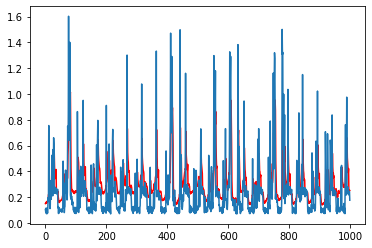

In [30]:
# Train and test for mse and r2 for one house
id = 2
home = pd.read_feather(f_data_path+f"TestId{id}.feather")
_labels = home['energy'].copy()
_data = home.drop('energy', axis=1)

regressor = SGDRegressor()

regressor.partial_fit(_data, _labels) ## Partially fitting data in batches
TestModel(regressor,_data, _labels, mean_squared_error, "home")
p = TestModel(regressor,_data, _labels, r2_score, "home")

plt.plot(p[0][5000:6000], color="red")
plt.plot(_labels[5000:6000].reset_index(drop=True))

      home             mean_squared_error : 0.05059424871144717
      home                       r2_score : 0.3556497891069097


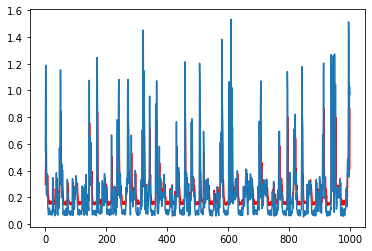

In [37]:
id = 100
home = pd.read_feather(f_data_path+f"TestId{id}.feather")
_labels2 = home['energy'].copy()
_data2 = home.drop('energy', axis=1)

regressor.partial_fit(_data2, _labels2) ## Partially fitting data in batches
TestModel(regressor,_data2, _labels2, mean_squared_error, "home")
p = TestModel(regressor,_data2, _labels2, r2_score, "home")

plt.plot(p[0][5000:6000], color="red")
plt.plot(_labels2[5000:6000].reset_index(drop=True))

### Test Trained Models SDG

In [7]:
from sklearn.metrics import mean_squared_error, r2_score
# lenData = test_b_size = 11
lenData = test_b_size = 10
mseScores = []
r2Scores = []
# path = "Models/SDGReg_hh_clean/"
#path = "Models/SDGReg_hh_all/"
path = 'Models/MLReg_hh_10.20.5/'

for k in range(save_after, epochs + save_after, save_after):
    model = joblib.load(path + f"{k}_epoch.pickle")
    (m,r) = TestModelOnBatch(model,x_test_batches, y_test, [mean_squared_error,r2_score],"model all")
    mseScores.append(m)
    r2Scores.append(r)

|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
 model all             mean_squared_error : 0.029312875138370973
 model all                       r2_score : 0.666754684619829
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
 model all             mean_squared_error : 0.03005808516648811
 model all                       r2_score : 0.6582827162553446
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
 model all             mean_squared_error : 0.02882079015389924
 model all                       r2_score : 0.6723489845672084
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
 model all             mean_squared_error : 0.028838167424068292
 model all                       r2_score : 0.6721514299482707
|██████████████████████████████████████████████

In [33]:
for i in range(len(mseScores)):
    print(mseScores[i-1] - mseScores[i])

-6.882299877875031e-05
6.754487742202664e-05
4.4227762382650915e-06
-2.9816845435896855e-05
2.703624027217827e-05
-1.2923361660040211e-05
7.478438500060913e-06
7.772822549038938e-06
-8.105995173285363e-06
5.414046066402889e-06


In [6]:
samples = 4

l_energy_days = [f"energy_{i}" for i in range(0,samples)]
l_dprec = ['dayPrecent']
l_yprec = ['yearPrecent']
l_acorn = ['Acorn_category']
l_temp = ['temperature']
l_holi = ['holiday_ind']


for s in range(samples):
    TestWithout(energy_hh_clean,energy_hh_clean_labels,"hh_past_energy_noperc_",s, l_energy_days[s:]+ l_dprec + l_yprec)
for s in range(samples):
    TestWithout(energy_hh_clean,energy_hh_clean_labels,"hh_past_energy_",s,   l_energy_days[s:])
    
TestWithout(energy_hh_clean,energy_hh_clean_labels,"hh_day_perc_holi",s,   l_energy_days[s:] + l_yprec + l_acorn + l_temp )
TestWithout(energy_hh_clean,energy_hh_clean_labels,"hh_year_perc_holi",s,  l_energy_days[s:] + l_dprec + l_acorn + l_temp )
TestWithout(energy_hh_clean,energy_hh_clean_labels,"hh_acorn_holi",s,      l_energy_days[s:] + l_yprec + l_dprec + l_temp )
TestWithout(energy_hh_clean,energy_hh_clean_labels,"hh_temp_holi",s,       l_energy_days[s:] + l_yprec + l_acorn + l_dprec)

TestWithout(energy_hh_clean,energy_hh_clean_labels,"hh_day_perc",s,   l_energy_days[s:] + l_yprec + l_acorn + l_temp + l_holi)
TestWithout(energy_hh_clean,energy_hh_clean_labels,"hh_year_perc",s,  l_energy_days[s:] + l_dprec + l_acorn + l_temp + l_holi)
TestWithout(energy_hh_clean,energy_hh_clean_labels,"hh_acorn",s,      l_energy_days[s:] + l_yprec + l_dprec + l_temp + l_holi)
TestWithout(energy_hh_clean,energy_hh_clean_labels,"hh_temp",s,       l_energy_days[s:] + l_yprec + l_acorn + l_dprec+ l_holi)


################################
	 day: 0


# Save Test Resoults 

In [13]:
#Save resaults
test = pd.DataFrame(resaults_mean)
test.to_csv("Results/avg_hh_best_r2_test2.csv", mode='w', index=False, header=True) 
test = pd.DataFrame(resaults_std)
test.to_csv("Results/avg_hh_best_r2_test2_std.csv", mode='w', index=False, header=True) 
test = pd.DataFrame(resaults_time)
test.to_csv("Results/avg_hh_best_r2_test2_time.csv", mode='w', index=False, header=True) 


In [37]:
print("Mean values:")
pd.DataFrame(resaults_mean)


Mean values:


,LinReg,SGDReg,ElaNet,Lasso,Ridge,SVR,TreeReg,ExTreeR,ForestR,XGBReg,KNeighR,lable
0,0.050009,0.050325,0.077287,0.077287,0.050009,0.054293,0.028976,0.021965,0.023344,0.015007,0.040908,avg_hh_past_energy_and_energyDiff0
1,0.011735,0.011839,0.077287,0.077287,0.011735,0.051371,0.012087,0.007720,0.008449,0.007249,0.018737,avg_hh_past_energy_and_energyDiff1
2,0.050009,0.050072,0.077287,0.077287,0.050009,0.054293,0.028854,0.021956,0.023403,0.014908,0.040908,avg_hh_past_energy_noperc_0
3,0.015594,0.015617,0.077287,0.077287,0.015594,0.050836,0.011918,0.008167,0.008849,0.007301,0.018221,avg_hh_past_energy_noperc_1
4,0.011735,0.011860,0.077287,0.077287,0.011737,0.049870,0.011930,0.007964,0.008386,0.007145,0.017089,avg_hh_past_energy_noperc_2
...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.050004,0.050060,0.077287,0.077287,0.049997,0.054216,0.028819,0.021828,0.023389,0.013219,0.040392,avg_hh_noholiday_ind4
91,0.049554,0.049580,0.077287,0.077287,0.049554,0.051913,0.029867,0.025040,0.025713,0.016672,0.027309,avg_hh_notime_noholiday_ind4
92,0.063056,0.063599,0.077287,0.077287,0.063049,0.050946,0.034884,0.029489,0.032110,0.012903,0.042510,avg_hh_no_temp4
93,0.060374,0.060162,0.077287,0.077287,0.060373,0.047409,0.031349,0.031352,0.030812,0.022632,0.029091,avg_hh_no_temp_notime4


In [17]:
print("Standard deviation:")
pd.DataFrame(resaults_std)


Standard deviation:


,LinReg,SGDReg,ElaNet,Lasso,Ridge,SVR,TreeReg,ExTreeR,ForestR,XGBReg,KNeighR,lable
0,0.006556,0.006605,0.012447,0.012447,0.006556,0.004538,0.009047,0.006839,0.008324,0.000421,0.015425,avg_hh_past_energy_and_energyDiff0
1,0.006372,0.006387,0.012447,0.012447,0.006372,0.005577,0.005568,0.004509,0.005093,0.000249,0.006735,avg_hh_past_energy_and_energyDiff1


In [18]:
print("Train Time:")
pd.DataFrame(resaults_time)

Train Time:


,LinReg,SGDReg,ElaNet,Lasso,Ridge,SVR,TreeReg,ExTreeR,ForestR,XGBReg,KNeighR,lable
0,5.215957,0.366988,0.207271,0.221990,0.236998,3.933307,1.015945,25.647837,33.542106,9.537119,10.602700,avg_hh_past_energy_and_energyDiff0
1,0.224948,0.333272,0.224010,0.248989,0.235000,1.245595,1.172834,37.299442,61.744531,13.293854,4.804009,avg_hh_past_energy_and_energyDiff1


# Train "Best" model

### Create data

In [51]:
energy_avg_hh = pd.read_csv(f_data_path + f_energy_avg_hhourly_name+"_all_added_past.csv")

pipeline_avg_hh = Pipeline([
        ('AddDayPrecent', AddDayPercentage()),
        ('AddYearPrecent', AddYearPercentage()),
        ('std_scaler', StdScaler(features=['dayPrecent','yearPrecent'], data_tags=[]))
    ])
    
energy_avg_hh = pipeline_avg_hh.fit_transform(energy_avg_hh.copy())

col = ['avg_energy','temperature','holiday_ind','Acorn_category','dayPrecent','yearPrecent','avg_energy_0','avg_energy_1','avg_energy_2','avg_energy_3']
energy_avg_hh['Acorn_category'] = 0.0
energy_avg_hh.reset_index(drop=True,inplace=True)
e = energy_avg_hh[col]
e.to_csv(f_data_path + f_energy_avg_hhourly_name+"_selected.csv",index=False)
del e

### Load Data 

#### Load No Std

In [136]:
# Read no Std avg data 
energy_avg_hh = pd.read_csv(f_data_path + f_energy_avg_hhourly_name+"_best_no_std.csv") 
col = ['avg_energy','temperature','holiday_ind','Acorn_category','dayPrecent','yearPrecent','avg_energy_0','avg_energy_1','avg_energy_2','avg_energy_3']
#col = ['avg_energy','temperature','holiday_ind','Acorn_category','dayPrecent','yearPrecent']
energy_avg_hh['Acorn_category'] = 0.0
energy_avg_hh.reset_index(drop=True,inplace=True)
energy_avg_hh = energy_avg_hh[col]
energy_avg_hh['dayPrecent'] = -np.sin((energy_avg_hh['dayPrecent']- 1/24) * (2 * math.pi * 24/23))
energy_avg_hh['yearPrecent'] = np.cos((energy_avg_hh['yearPrecent'] - 1/12) * (2 * math.pi * 12/11))

#### Add Data and energy from previous day at the same time 

##### Transform

In [49]:
energy_avg_hh = pd.read_csv(f_data_path + f_energy_avg_hhourly_name+"_best_no_std.csv") 
#col = ['avg_energy','minute','hour','day','month','year','temperature','holiday_ind','dayPrecent','yearPrecent']
#energy_avg_hh = energy_avg_hh[col]
energy_avg_hh['dayPrecent'] = -np.sin((energy_avg_hh['dayPrecent']) * (2 * math.pi))
energy_avg_hh['yearPrecent'] = np.cos((energy_avg_hh['yearPrecent'] - 1/12) * (2 * math.pi * 12/11))

In [50]:
energy_avg_hh['year'] = energy_avg_hh['year'] + 1792
cols = energy_avg_hh[['year','month','day','hour','minute']]
energy_avg_hh['date'] = pd.to_datetime(cols,errors='coerce')

In [51]:
p = energy_avg_hh['date'] - pd.to_timedelta(1, unit='d')
b = p.isin(energy_avg_hh['date'])
energy_avg_hh['pastET'] = 0.0
energy_avg_hh.loc[b,'pastET'] =  energy_avg_hh.loc[energy_avg_hh['date'].isin(p),'avg_energy'].values

In [52]:
energy_avg_hh['Acorn_category'] = 0.0

In [53]:
col = ['avg_energy', 'temperature', 'holiday_ind', 'Acorn_category','dayPrecent', 'yearPrecent', 'pastET', 'avg_energy_0', 'avg_energy_1', 'avg_energy_2','avg_energy_3']
#col = ['avg_energy','temperature','holiday_ind','dayPrecent','yearPrecent','pastET']
energy_avg_hh = energy_avg_hh[col]


##### Save / Load

In [95]:
#energy_avg_hh.to_csv(f_data_path + 'energy_avg_All_good.csv', index=False)
energy_avg_hh = pd.read_csv(f_data_path + 'energy_avg_All_good.csv')
#energy_avg_hh = pd.read_csv(f_data_path + 'energy_avg_pastET_dprec_yprec.csv')

In [96]:
energy_avg_hh

,avg_energy,temperature,holiday_ind,Acorn_category,dayPrecent,yearPrecent,pastET,avg_energy_0,avg_energy_1,avg_energy_2,avg_energy_3
0,0.110286,7.670,0,0.0,-2.588190e-01,0.991131,0.000000,0.098000,0.153333,0.280500,0.284500
1,0.193000,8.260,0,0.0,-1.305262e-01,0.991131,0.000000,0.110286,0.098000,0.153333,0.280500
2,0.394222,8.840,0,0.0,-1.224647e-16,0.991131,0.000000,0.193000,0.110286,0.098000,0.153333
3,0.304100,9.350,0,0.0,1.305262e-01,0.991131,0.000000,0.394222,0.193000,0.110286,0.098000
4,0.258333,9.870,0,0.0,2.588190e-01,0.991131,0.000000,0.304100,0.394222,0.193000,0.110286
...,...,...,...,...,...,...,...,...,...,...,...
39713,0.299760,4.100,0,0.0,5.000000e-01,0.466667,0.294799,0.319743,0.334706,0.344755,0.347004
39714,0.285163,4.016,0,0.0,3.826834e-01,0.466667,0.275410,0.299760,0.319743,0.334706,0.344755
39715,0.252274,3.930,0,0.0,2.588190e-01,0.466667,0.248686,0.285163,0.299760,0.319743,0.334706
39716,0.215284,7.465,0,0.0,1.305262e-01,0.466667,0.207032,0.252274,0.285163,0.299760,0.319743


#### Load Selected

In [5]:
energy_avg_hh = pd.read_csv(f_data_path + f_energy_avg_hhourly_name+"_selected.csv")

_labels = energy_avg_hh['avg_energy'].copy()
_data = energy_avg_hh.drop('avg_energy', axis=1)
del energy_avg_hh

### Split Data 

In [97]:
_labels = energy_avg_hh['avg_energy'].copy()
_data = energy_avg_hh.drop('avg_energy', axis=1)
del energy_avg_hh

In [6]:
avg_train_data, avg_test_data, avg_train_lables, avg_test_lables = train_test_split(_data, _labels, train_size=0.8, random_state=123)
del _data
del _labels

### Train PassiveAgressiv 

In [42]:
from sklearn.linear_model import PassiveAggressiveRegressor

sdgReg = SGDRegressor()
xgbReg = xgboost.XGBRegressor(objective='reg:squarederror',n_estimators=20)
pasAgrReg = PassiveAggressiveRegressor()

sdgReg = sdgReg.fit(avg_train_data,avg_train_lables)
xgbReg = xgbReg.fit(avg_train_data,avg_train_lables)
pasAgrReg = pasAgrReg.fit(avg_train_data,avg_train_lables)

In [43]:
joblib.dump(sdgReg, f'Models/sdgRegAll.pickle')
joblib.dump(xgbReg, f'Models/xgbRegAll.pickle')
joblib.dump(pasAgrReg, f'Models/pasAgrRegAll.pickle')

['Models/pasAgrRegAll.pickle']

# Train ML with keras

In [4]:
import tensorflow as tf
from tensorflow import keras

In [51]:
x_train_batches[0] = x_train_batches[0].astype('f4')
y_train_batches[0] = y_train_batches[0].astype('f4')

In [44]:
s = StandardScaler()
x_train_batches[0] = s.fit_transform(x_train_batches[0])

In [68]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(10, input_shape=[None,10]),
    #keras.layers.Flatten(input_shape=x_train_batches[0].shape[1:]),
    #keras.layers.Dense(1)
    #keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
])

model.compile(loss="mean_squared_error", optimizer="sgd")


In [69]:

history = model.fit(x_train_batches[0], y_train_batches[0], batch_size=8196, epochs=20, validation_split=0.2)


Epoch 1/20


ValueError: in user code:

    c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\keras\engine\training.py:787 train_step
        y_pred = self(x, training=True)
    c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\keras\engine\input_spec.py:218 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential_16 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 10)


In [ ]:
train_b_size = 87
epochs = 5 #; l = 1493606
save_after = 1
path = 'Models/MLReg_hh_10.20.5/'

lenData = train_b_size
for k in range(1,epochs + 1): ## Number of loops through data
    print(f"epoch: {k}")
    for i in range(0,lenData): ## Looping through batches
        regressor = regressor.partial_fit(x_train_batches[i], y_train_batches[i]) ## Partially fitting data in batches

        progres_bar((i+1)*save_after,save_after*lenData)
    if k % save_after == 0:
        joblib.dump(regressor, path + f'{k}_epoch.pickle')
        # if k != epochs:
        #     progres_bar(0,save_after*lenData)

In [11]:
x_test_batches[0] = x_test_batches[0].astype('f4')
y_test_batches[0] = y_test_batches[0].astype('f4')

(0.0, 1.0)

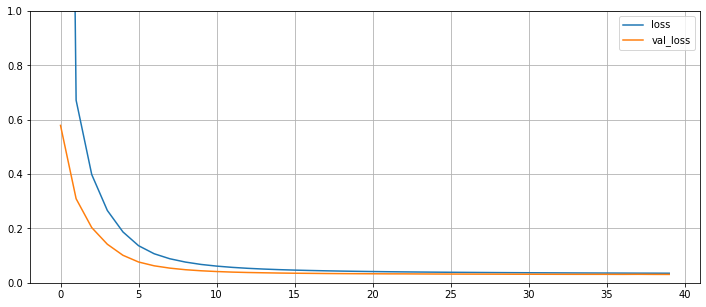

In [43]:
pd.DataFrame(history.history).plot(figsize=(12,5),grid=True)
plt.gca().set_ylim(0, 1)

In [12]:
mse_test = model.evaluate(x_test_batches[0], y_test_batches[0])
# X_new = X_test[:3] # pretend these are new instances
# y_pred = model.predict(X_new)

52744/52744 [==============================] - 148s 3ms/step - loss: 0.0333


TypeError: 'NoneType' object is not subscriptable

In [ ]:
mse_test

0.0333382822573185

In [27]:
pred = model.predict(_data.astype('f4'))
mse = mean_squared_error(pred, _labels)

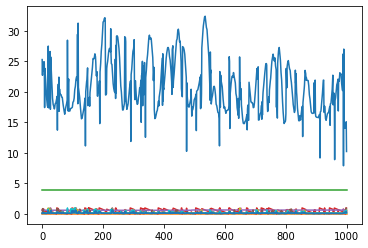

In [30]:
plt.plot(_data[:1000])
plt.plot(pred[:1000])

# Compear Clean Data model to avg model 

In [118]:
# modelsPath = ['sdgReg.pickle','sdgRegNoStd.pickle','sdgRegNoStdSinTime.pickle', 'sdgRegNoStdSinTimeCosY.pickle' ]
# modelNames = ["SDGReg on AVG", "SDGReg no STD",'SDGReg sin Time', 'SDGReg sin T Cos Y']
# modelsPath = ['sdgRegNoStdSinTimeCosYpastET.pickle','xgbRegNoStdSinTimeCosYpastET.pickle' ]
# modelNames = [ 'SDGReg pastET and sincos','xgbReg pastET and sincos']
modelsPath = ['MLReg_hh_10.20.5/1_epoch.pickle','MLReg_hh_10.20.5/2_epoch.pickle','pasAgrRegAll.pickle','sdgRegAll.pickle','xgbRegAll.pickle', 'SDGReg_hh_all/2_epoch.pickle','PasAgrReg_hh_clean/1_epoch.pickle']
modelNames = ['gs','MLReg all 1','MLReg all 2','pasAgrReg all', 'SDGReg All','xgbReg All','model e2','model pasAgr ']
# modelsPath = ['Models/sdgRegNoStdSinTimeNoPast.pickle','Models/xgbRegNoStdSinTimeNoPast.pickle']
# modelNames = ['sdgReg no past sin', 'xgbReg no past sin']
funcs = [mean_squared_error,r2_score]
models = [gs]
for p in modelsPath:
    models.append(joblib.load('Models/' + p))

In [5]:
# On Avg data 
for i, m in enumerate(models):
    TestModel(m,avg_test_data,avg_test_lables,funcs,modelNames[i])



NameError: name 'avg_test_data' is not defined

In [119]:
# on batched Clean all data 
for i, m in enumerate(models):
    _ = TestModelOnBatch(m,x_test_batches,y_test,funcs,modelNames[i])



ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 11 is different from 10)

In [4]:
0.02843914660204237 / np.mean(y_test)

NameError: name 'y_test' is not defined

In [34]:
np.mean(y_test)

0    0.212166
dtype: float32

In [25]:
model = joblib.load(f"Models/SDGReg_hh_sin/10_epoch.pickle")
_=TestModelOnBatch(model,x_test_batches,y_test,[mean_squared_error,r2_score],"SDGReg All")



|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
SDGReg All             mean_squared_error : 0.03300037255386335
SDGReg All                       r2_score : 0.6232757589985509


# Predict for one houshold

### Load Data 

In [116]:
id = 3
# home = pd.read_feather(f_data_path+f"TestId{id}.feather")
# home['dayPrecent'] = -np.sin((home['dayPrecent'] - 1/24) * (2 * math.pi * 24/23))
# home['yearPrecent'] = np.cos((home['yearPrecent'] - 1/12) * (2 * math.pi * 12/11))
home = pd.read_feather(f_data_path+f"TestAllId{id}.feather")
# col = ['energy','temperature','holiday_ind','dayPrecent','yearPrecent','pastET']
# home = home[col]
_labels = home['energy'].copy()
_data = home.drop('energy', axis=1)
del home

In [28]:
modelsPath = ['Models/sdgReg.pickle','Models/xgbReg.pickle', 'Models/sdgRegNoStd.pickle','Models/xgbRegNoStd.pickle',
            "Models/SDGReg_hh_no_std/4_epoch.pickle","Models/SDGReg_hh_sin/10_epoch.pickle"]
modelNames = ["SDGReg on AVG", "xgbReg on AVG", "SDGReg no STD", "xgbReg no STD","model all no STD", "model sin time"]
funcs = [mean_squared_error, r2_score, mean_absolute_percentage_error,mean_absolute_error,median_absolute_error]
models = []
for p in modelsPath:
    models.append(joblib.load(p))

### Test

In [117]:
preds = [] 
for i,m in enumerate(models):
    preds.append(TestModel(m,_data,_labels,funcs, modelNames[i]))


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 11 is different from 10)

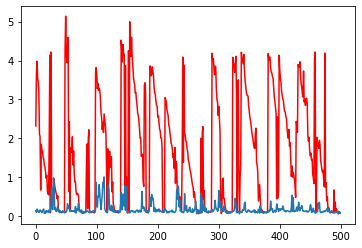

In [11]:
start = 0
end = 500
#plt.plot(preds[0][start:end],color="red")
#plt.plot(preds[1][start:end],color="green")
plt.plot(preds[0][0][start:end],color="red")
plt.plot(_labels[start:end].values)


In [21]:
d = x_test_batches[0]
d['energy'] = y_test_batches[0]
d.corr()

,temperature,holiday_ind,Acorn_category,dayPrecent,yearPrecent,pastET,energy_0,energy_1,energy_2,energy_3,energy
temperature,1.000000,-0.015529,0.000113,-0.154970,-0.084550,-0.073074,-0.078214,-0.080345,-0.082651,-0.085751,-0.077516
holiday_ind,-0.015529,1.000000,0.000210,-0.000846,-0.013170,0.002810,0.002464,0.002604,0.002753,0.002454,0.002171
Acorn_category,0.000113,0.000210,1.000000,-0.000171,-0.005969,-0.101246,-0.101060,-0.100806,-0.101468,-0.101740,-0.101851
dayPrecent,-0.154970,-0.000846,-0.000171,1.000000,0.000576,-0.171249,-0.174957,-0.172686,-0.164061,-0.148132,-0.170278
yearPrecent,-0.084550,-0.013170,-0.005969,0.000576,1.000000,0.001950,-0.000029,0.000178,-0.000772,-0.000727,-0.000189
pastET,-0.073074,0.002810,-0.101246,-0.171249,0.001950,1.000000,0.581571,0.541445,0.508681,0.480528,0.613961
energy_0,-0.078214,0.002464,-0.101060,-0.174957,-0.000029,0.581571,1.000000,0.779925,0.660409,0.592972,0.780838
energy_1,-0.080345,0.002604,-0.100806,-0.172686,0.000178,0.541445,0.779925,1.000000,0.779235,0.660638,0.660564
energy_2,-0.082651,0.002753,-0.101468,-0.164061,-0.000772,0.508681,0.660409,0.779235,1.000000,0.781977,0.591699
energy_3,-0.085751,0.002454,-0.101740,-0.148132,-0.000727,0.480528,0.592972,0.660638,0.781977,1.000000,0.542677


In [79]:
model = joblib.load(f"Models/SDGReg_hh_all/2_epoch.pickle")
org = _labels[:480]
predorg = _labels[480:480+48]

dataT = _data.loc[480:480+48,['temperature','holiday_ind','Acorn_category','dayPrecent','yearPrecent','pastET']].reset_index(drop=True)
sd = _data.iloc[481].copy()


In [33]:
sd

temperature          13.66
holiday_ind          False
Acorn_category          16
dayPrecent        0.895996
yearPrecent       0.519999
pastET            0.167969
energy_0          0.192017
energy_1          0.234009
energy_2          0.162964
energy_3          0.162964
Name: 481, dtype: object

In [81]:
preds = []
for i in range(48):
    newe = model.predict(sd.values.reshape(1,-1))
    preds.append(newe[0])
    sd.loc['energy_3'] = sd['energy_2']
    sd.loc['energy_2'] = sd['energy_1']
    sd.loc['energy_1'] = sd['energy_0']
    sd.loc['energy_0'] = newe[0]
    sd.loc['temperature'] = dataT.loc[i,'temperature']
    sd.loc['dayPrecent'] = dataT.loc[i,'dayPrecent']
    sd.loc['yearPrecent'] = dataT.loc[i,'yearPrecent']
    sd.loc['pastET'] = dataT.loc[i,'pastET']



In [94]:
mean_squared_error(predorg,preds),mean_absolute_percentage_error(predorg,preds)

(0.12486960930950448, 0.8182172597585229)

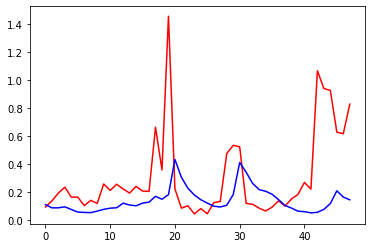

In [87]:
#plt.plot(org,color='blue')
plt.plot(predorg.reset_index(drop=True),color='red')
plt.plot(preds,color='blue')
plt.show()

In [26]:
sum(preds[0]), sum(_labels), sum(sdgPred),sum(xgbPred)

(5621.003999527087, 6094.876000203192, 5290.6069880569075, 5783.313746243715)

In [22]:
sdgPredscale = sdgPred * (1/sdgPred.max()*_labels.max())

# Optimalization with Grid Search  

In [123]:
model = SGDRegressor(penalty='elasticnet',max_iter=10**7,shuffle=True,early_stopping=True,validation_fraction=0.1,n_iter_no_change=10)
#model.fit(X,y)

print("CV starts.")
# run grid search
param_grid = [{
    'alpha' : 10.0**-np.arange(4,9),
    'l1_ratio':[0, .05, .15, .5, .7, .9, .95, .99, 1]
    }]
gs = GridSearchCV(model,param_grid,n_jobs=8,verbose=0,scoring='neg_mean_squared_error', return_train_score=True)
gs.fit(_data, _labels)
gs.fit(x_test_batches[0], y_test_batches[0])

CV starts.


GridSearchCV(estimator=SGDRegressor(early_stopping=True, max_iter=10000000,
                                    n_iter_no_change=10, penalty='elasticnet'),
             n_jobs=8,
             param_grid=[{'alpha': array([1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08]),
                          'l1_ratio': [0, 0.05, 0.15, 0.5, 0.7, 0.9, 0.95, 0.99,
                                       1]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [124]:
gs.best_params_

{'alpha': 0.0001, 'l1_ratio': 0.9}

In [125]:
cvres = gs.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

0.03070506755246128 {'alpha': 0.0001, 'l1_ratio': 0}
0.030526814860949113 {'alpha': 0.0001, 'l1_ratio': 0.05}
0.03053784167470953 {'alpha': 0.0001, 'l1_ratio': 0.15}
0.030782069941493406 {'alpha': 0.0001, 'l1_ratio': 0.5}
0.031197750297994587 {'alpha': 0.0001, 'l1_ratio': 0.7}
0.030472560150870843 {'alpha': 0.0001, 'l1_ratio': 0.9}
0.030476577158702854 {'alpha': 0.0001, 'l1_ratio': 0.95}
0.03075341715404814 {'alpha': 0.0001, 'l1_ratio': 0.99}
0.030702411035726657 {'alpha': 0.0001, 'l1_ratio': 1}
0.030563639497825236 {'alpha': 1e-05, 'l1_ratio': 0}
0.030595434479062385 {'alpha': 1e-05, 'l1_ratio': 0.05}
0.03049204175836797 {'alpha': 1e-05, 'l1_ratio': 0.15}
0.03064480345730648 {'alpha': 1e-05, 'l1_ratio': 0.5}
0.03051554453512555 {'alpha': 1e-05, 'l1_ratio': 0.7}
0.030556092590450057 {'alpha': 1e-05, 'l1_ratio': 0.9}
0.030529706944694625 {'alpha': 1e-05, 'l1_ratio': 0.95}
0.0309331485785877 {'alpha': 1e-05, 'l1_ratio': 0.99}
0.030533174924181127 {'alpha': 1e-05, 'l1_ratio': 1}
0.0309128

In [78]:
param_grid = [
    {'n_estimators': [3, 10, 30, 50], 'max_features': [2, 4, 8, 16, 21]},
    {'bootstrap': [False], 'n_estimators': [3, 10 , 30 , 50], 'max_features': [2, 4, 8, 16, 21]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(energy_tr, energy_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 8, 16, 21],
                          'n_estimators': [3, 10, 30, 50]},
                         {'bootstrap': [False],
                          'max_features': [2, 4, 8, 16, 21],
                          'n_estimators': [3, 10, 30, 50]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [79]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 50}

In [80]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1.8828952186062002 {'max_features': 2, 'n_estimators': 3}
1.3452599500830404 {'max_features': 2, 'n_estimators': 10}
1.0910316284266925 {'max_features': 2, 'n_estimators': 30}
1.0696205622836068 {'max_features': 2, 'n_estimators': 50}
1.2251345556538475 {'max_features': 4, 'n_estimators': 3}
1.398524321200443 {'max_features': 4, 'n_estimators': 10}
1.3036456818121962 {'max_features': 4, 'n_estimators': 30}
1.1633464869213932 {'max_features': 4, 'n_estimators': 50}
1.393035401373218 {'max_features': 8, 'n_estimators': 3}
1.946273684185477 {'max_features': 8, 'n_estimators': 10}
1.3422822484775436 {'max_features': 8, 'n_estimators': 30}
1.744389474549438 {'max_features': 8, 'n_estimators': 50}
2.533334769638574 {'max_features': 16, 'n_estimators': 3}
1.7677375876563481 {'max_features': 16, 'n_estimators': 10}
1.7409335056467463 {'max_features': 16, 'n_estimators': 30}
1.86970262554365 {'max_features': 16, 'n_estimators': 50}
2.784389129832759 {'max_features': 21, 'n_estimators': 3}
1.979

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [81]:
param_grid = [
    {'n_estimators': [3, 10, 30, 50], 'max_features': [2, 4, 8, 16, 21]},
    {'bootstrap': [False], 'n_estimators': [3, 10 , 30 , 50], 'max_features': [2, 4, 8, 16, 21]},
  ]

lin_reg = LinearRegression()

grid_search = GridSearchCV(lin_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(energy_tr, energy_labels)

ValueError: Invalid parameter max_features for estimator LinearRegression(). Check the list of available parameters with `estimator.get_params().keys()`.

In [83]:
lin_reg.get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'])

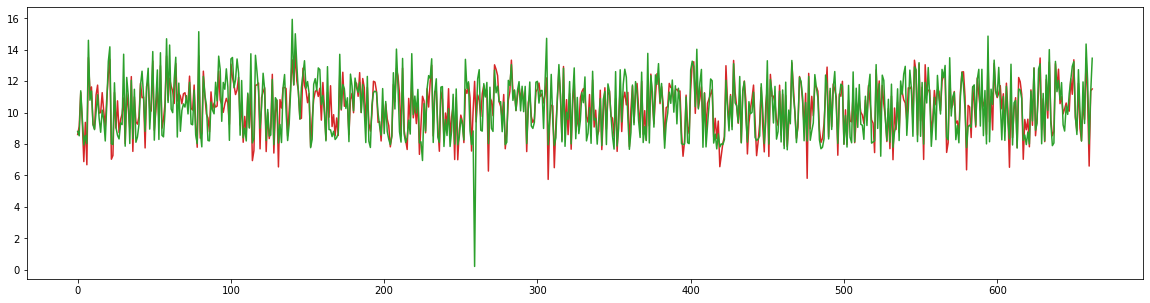

In [37]:
figure, axis = plt.subplots(figsize = (20,5))
axis.plot(range(len(energy_predictions)), energy_predictions, color = 'tab:red')
axis.plot(range(len(energy_labels)), energy_labels, color = 'tab:green')
  


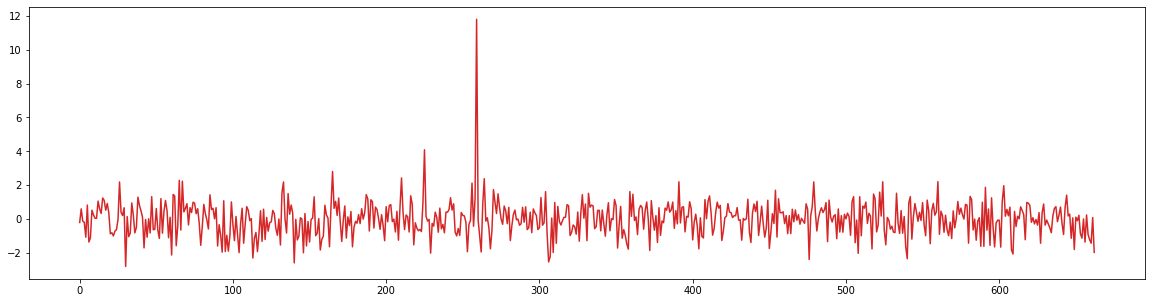

In [40]:
joblib.dump(my_model, "my_model.pkl")
my_model_loaded = joblib.load("my_model.pkl")